In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3107157357285725231
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 1573119590
locality {
  bus_id: 1
}
incarnation: 16992733450922786254
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0"
]


Using TensorFlow backend.


original image shape:  <PIL.Image.Image image mode=RGB size=224x224 at 0x22FFF97C7B8>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


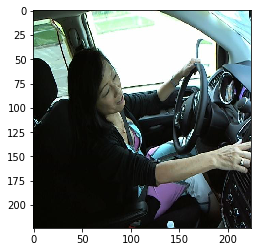

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


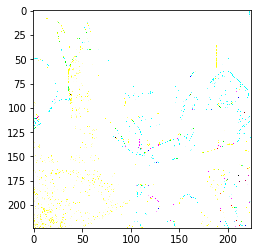

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


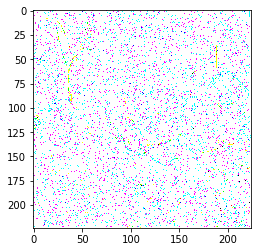

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


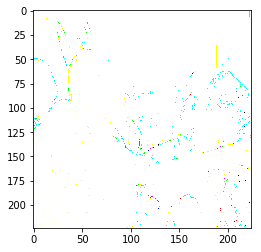

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


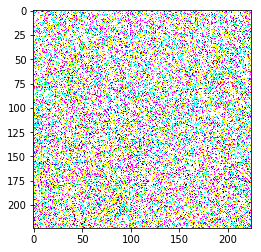

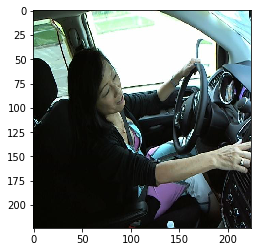

In [2]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing import image
from PIL import Image

def plot_histogram(image):
    hist,bins = np.histogram(image.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

def equalize_histogram(img, grid_size):
    clahe = cv2.createCLAHE(tileGridSize=(grid_size,grid_size))
    cl1 = clahe.apply(img)
    return cl1

# img = cv2.imread('./images/train/c0/img_34.jpg', 0)
# equalized_img = equalize_histogram(img,16)
# plt.imshow(equalized_img)
# plt.show()
# plot_histogram(equalized_img)

# ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
# plt.imshow(equalized_img)
# plt.show()
# plot_histogram(equalized_img)

def equalize_histogram(local_img, grid_size):
#    local_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(tileGridSize=(grid_size,grid_size))
    equalized_img = clahe.apply(local_img)
    return equalized_img

def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    print ("channels: ", len(channels))
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img
    
def noisy(noise_typ,image):
    if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = .1
      var = 0.1
      sigma = var**0.1
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
    elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.6
      amount = 0.08
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
    elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
    elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

def shift(img):
#     rows,cols,channels = img.shape
#     M = np.float32([[1,0,1],[0,1,1]])
#     img = cv2.warpAffine(img,M,(cols,rows))
    return img

img = image.load_img('./images/train/c5/img_56.jpg', target_size=(224, 224), grayscale=False)
print("original image shape: ", img)
img2 = np.array(img)
print(type(img2))
# eq_img = equalize_histogram(img,16)
# plt.imshow(eq_img)
# plt.show()
img = image.img_to_array(img) 
print(type(img))
plt.imshow(img/255)
plt.show()

# kernel = np.ones((8,8),np.uint8)
# gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
# plt.imshow(gradient)
# plt.show()

# tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
# plt.imshow(tophat)
# plt.show()

# blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
# plt.imshow(blackhat)
# plt.show()

# dilation = cv2.dilate(img,kernel,iterations = 1)
# plt.imshow(dilation)
# plt.show()

# ret, thresh = cv2.threshold(img, 127, 255, 0)
# im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contour = cv2.drawContours(img, contours, -1, (0,255,0), 3)
# plt.imshow(contour)
# plt.show()

plt.imshow(noisy('gauss', img))
plt.show()
plt.imshow(noisy('s&p', img))
plt.show()
plt.imshow(noisy('poisson', img))
plt.show()
plt.imshow(noisy('speckle', img))
plt.show()

plt.imshow(shift(img/255))
plt.show()

In [3]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model
import datetime, random, pickle
from sklearn.datasets import load_files
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ActivityRegularization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
import sys
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def loadImages(path):
    data = load_files(path)
    files = data['filenames']
    targets = data['target']
    target_names = data['target_names']
    return files, targets, target_names


def path_to_tensor(img_path, equalized=False, addNoise=False):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=equalized)
    if (equalized == True):
        img = np.array(img)
        #equalize histogram
        img = equalize_histogram(img, 16)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    if (addNoise == True):
        x = shift(x)
#         x = noisy('gauss', x)
#         if '34' in img_path:
#             plt.imshow(x/255)
#             plt.show()
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, equalized=False,addNoise=False):
    print (img_paths)
    list_of_tensors = [path_to_tensor(img_path,equalized,addNoise) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


# dictionary for distraction category to numerical value
catLabels = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

#Maps category value to categorical label in the catLabels object
def getClass(value):
    index = 'c' + str(value)
    return catLabels[index]

def displayImage(sample_image):
    gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [4]:
# ## Load the Data

print ("Loading Images...")
path = "images/train"
files, targets, target_names = loadImages(path)
# predict_files = np.array(glob("images/test/*"))[1:10]
print('Number of Categories: ', len(target_names))
print('Categories: ', target_names)

# Split the original training sets into training & testing sets
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.20, random_state=40)

print(train_files.shape, test_files.shape, train_targets.shape, test_targets.shape)
print(len(test_files))


Loading Images...
Number of Categories:  10
Categories:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
(15200,) (3800,) (15200,) (3800,)
3800


In [5]:
print ("Creating image tensors")

train_tensors = paths_to_tensor(train_files,equalized=False,addNoise=True).astype('float32') / 255
test_tensors = paths_to_tensor(test_files,equalized=False,addNoise=True).astype('float32') / 255

train_targets_onehot = np_utils.to_categorical(np.array(train_targets), 10)
test_targets_onehot = np_utils.to_categorical(np.array(test_targets), 10)

print("Size of train tensors: " + str(train_tensors.shape))
print("Size of test tensors: " + str(test_tensors.shape))
print("Size of test targets: " + str(test_targets.shape))


Creating image tensors
['images/train\\c3\\img_24663.jpg' 'images/train\\c8\\img_98810.jpg'
 'images/train\\c9\\img_67390.jpg' ..., 'images/train\\c7\\img_31727.jpg'
 'images/train\\c7\\img_82756.jpg' 'images/train\\c5\\img_21995.jpg']


100%|███████████████████████████████████████████████████████████████████████████| 15200/15200 [01:37<00:00, 155.86it/s]


['images/train\\c5\\img_68264.jpg' 'images/train\\c6\\img_69335.jpg'
 'images/train\\c2\\img_12280.jpg' ..., 'images/train\\c8\\img_6916.jpg'
 'images/train\\c6\\img_21610.jpg' 'images/train\\c5\\img_46343.jpg']


100%|█████████████████████████████████████████████████████████████████████████████| 3800/3800 [00:26<00:00, 145.47it/s]


Size of train tensors: (15200, 224, 224, 3)
Size of test tensors: (3800, 224, 224, 3)
Size of test targets: (3800,)


In [6]:
import glob

def predict_distraction(model):
    print("Evaluating...")
    scores = model.evaluate(test_tensors, test_targets_onehot, verbose=0)
    print("Evaluation %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    return

#model_files = glob.glob('./saved_models/create_model*.hdf5')
# for m in model_files:
#     if ('grayscale' not in m):
#         print(m)
#         model = load_model(m)
#         predict_distraction(model)
    #p = model.predict(test_tensors)



In [7]:
import glob
from keras.models import load_model

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#model_files = glob.glob('./saved_models/*.hdf5')
# for m in model_files:
#     print(m)
#     model = load_model(m)
#     #plot_model(model, to_file='./model_pics/' + m + '.png')
#     SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
"""
================
Confusion matrix
================

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.

"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()



Confusion matrix

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.




./saved_models/create_base_model2018-04-0112_complete_model.hdf5
Evaluating...
Evaluation acc: 24.08%
True target [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Predicted target [[ 0.11736853  0.0313586   0.02450428 ...,  0.02222406  0.01792988
   0.24750109]
 [ 0.10574752  0.03626604  0.07470337 ...,  0.04090364  0.0493618
   0.09667396]
 [ 0.08740102  0.06665746  0.09507573 ...,  0.05620072  0.09648257
   0.15982425]
 ..., 
 [ 0.09404718  0.05858643  0.05843198 ...,  0.09350591  0.03969447
   0.07508402]
 [ 0.0835459   0.10122389  0.0664992  ...,  0.11998558  0.0634357
   0.16482906]
 [ 0.17811494  0.04529898  0.05346827 ...,  0.03451232  0.02779518
   0.09291033]]
[[684  30  39 129 257 210  40   4   2 114]
 [178 346  42 167 257  22 251  21  11 187]
 [122 123 142 137 547  62 233  17  80  76]
 [419  77   5 209 468 226  37   1   1  74]

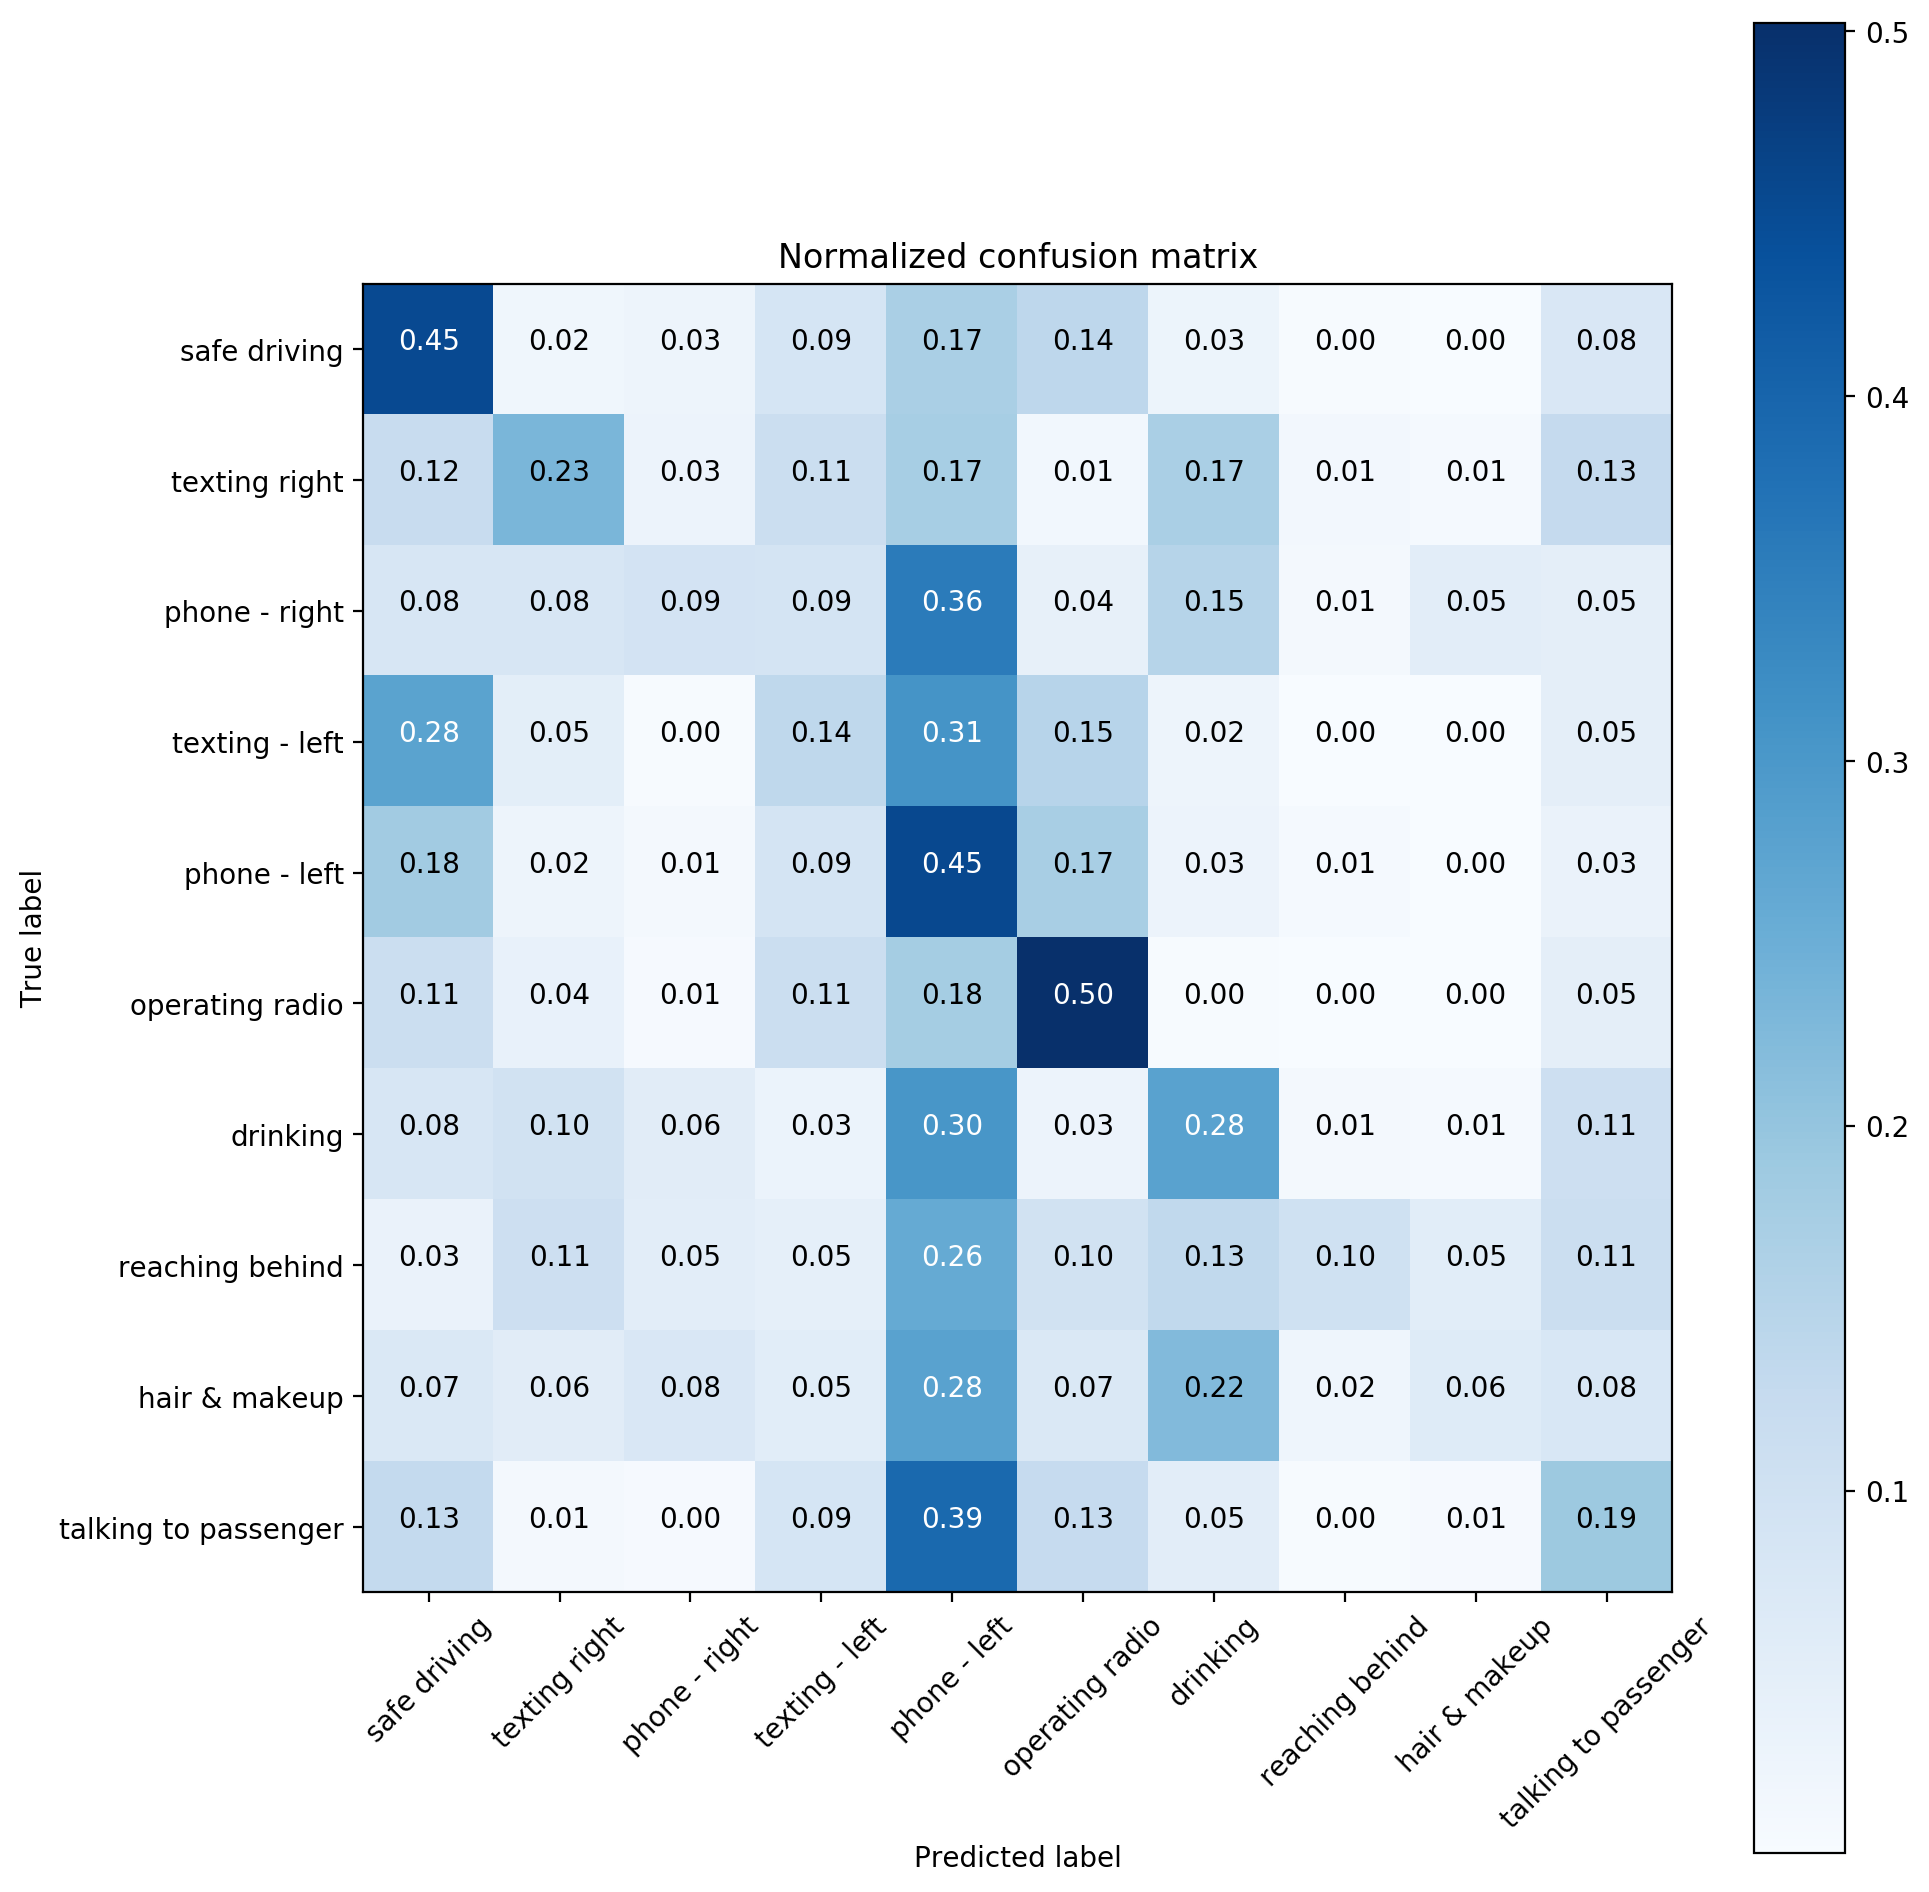

In [12]:
import glob
from keras.models import load_model
import numpy as np

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix

labels = ['safe driving',
            'texting right',
            'phone - right',
            'texting - left',
            'phone - left',
            'operating radio',
            'drinking',
            'reaching behind',
            'hair & makeup',
            'talking to passenger'
]


#num_images = 10
model_files = glob.glob('./saved_models/create_base_model2018-04-0112_complete_model.hdf5')
#model_files = glob.glob('./final_model/create_model23dropout_0.12018-03-2765_complete_model.hdf5')
#model_files = glob.glob('./saved_models/create_model23_grayscaledropout_0.12018-03-2988_complete_model.hdf5')
for m in model_files:
    print(m)
    model = load_model(m)
#     print(model.summary())
#     print(model.get_config())
    p = model.predict(train_tensors)
    predict_distraction(model)
    print("True target", train_targets_onehot)
#    pcat = np_utils.to_categorical(np.array(p), 10)
    print("Predicted target", p)
    matrix = confusion_matrix(train_targets, np.argmax(p,axis=1))
    print(matrix)
    plt.figure(figsize=(10,10), dpi=200)
    plot_confusion_matrix(matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

#     unlabeled_files = np.array(glob.glob("images/test/*2*"))[1:num_images]
#     print(unlabeled_files.shape)
#     unlabeled_tensors = paths_to_tensor(unlabeled_files).astype('float32') / 255
#     z = np.argmax(p, axis=1)
#     for i in range(1,num_images-1):
#         img = np.squeeze(np.array(unlabeled_tensors[i]))
#         displayImage(img)
#         print("Predicted class (above): ", getClass(z[i]))
    